In [19]:
# Link to Kaggle Competition: https://www.kaggle.com/competitions/jpx-tokyo-stock-exchange-prediction/overview

In [20]:
import sys
import os
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor


In [21]:
pd.set_option('display.max_columns', None)
sys.path.append('helper-files')

In [22]:
# Hyperparameters
LEARNING_RATE = 0.1
NUM_TREES = 100
np.random.seed(100)

In [23]:
# Read and preprocess the data
stock_data = pd.read_csv('stock_prices.csv', parse_dates=['Date'])
stock_data.sort_values(by=['Date', 'SecuritiesCode'], inplace=True)
stock_data_filtered = stock_data[stock_data["Date"] >= pd.Timestamp('2020-12-23')].reset_index(drop=True)


In [24]:
# Enhanced feature engineering function
def enhance_features(df):
    # Lag features
    for i in range(1, 4):
        lag_features = df[['High', 'Low', 'Open', 'Close', 'Volume']].shift(i)
        lag_features.columns = [f'{col}_lag_{i}' for col in lag_features.columns]
        df = pd.concat([df, lag_features], axis=1)

    # Weighted volume price
    for i in range(1, 4):
        df[f'vol_price_weight_{i}'] = np.log1p(df[f'Volume_lag_{i}'] * df[[f'{col}_lag_{i}' for col in ['High', 'Low', 'Open', 'Close']]].mean(axis=1))

    df['weighted_vol_price'] = np.log1p(df['Volume'] * df[['High', 'Low', 'Open', 'Close']].mean(axis=1))
    df['balance_of_power'] = (df['Open'] - df['Close']) / (df['High'] - df['Low'])
    df['high_low_diff'] = df['High'] - df['Low']
    df['open_close_diff'] = df['Close'] - df['Open']
    df['price_std_dev'] = df[['Open', 'Close', 'High', 'Low']].std(axis=1)

    # Log transformation of all float columns
    float_cols = df.select_dtypes(include=['float64']).columns
    df[float_cols] = df[float_cols].apply(np.log1p)

    # Date and time features
    df['weekday'] = df['Date'].dt.weekday
    df['day_of_year'] = df['Date'].dt.dayofyear
    df['week_of_year'] = df['Date'].dt.isocalendar().week
    df['month'] = df['Date'].dt.month
    df['season'] = ((df['month'] % 12) + 3) // 3

    # Replace inf and handle missing values
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)

    return df

# Apply feature engineering
enhanced_data = enhance_features(stock_data_filtered.copy())
enhanced_data['Target'] = stock_data_filtered['Target']
model_features = [col for col in enhanced_data.columns if col not in ['Date', 'SecuritiesCode', 'Target', 'RowId']]

# Prepare training and validation sets
validation_set = enhanced_data[enhanced_data['Date'] >= pd.Timestamp('2021-11-11')].copy()
training_set = enhanced_data[enhanced_data['Date'] < pd.Timestamp('2021-11-11')].copy()
X_train = training_set[model_features]
y_train = training_set['Target']
X_val = validation_set[model_features]
y_val = validation_set['Target']

In [25]:
# Function to train and evaluate models
def train_and_evaluate(model, X_train, y_train, X_val, y_val, name):
    model.fit(X_train, y_train)
    preds = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    print(f"{name} - RMSE: {rmse:.5f}, MAE: {mae:.5f}")
    return rmse, mae


In [26]:
# Initialize models
models = {
    "LightGBM": LGBMRegressor(n_estimators=NUM_TREES, learning_rate=LEARNING_RATE, random_state=42),
    "RandomForest": RandomForestRegressor(
    n_estimators=50,  # Reduced number of trees to speed up training
    max_depth=10,  # Limiting the depth of each tree
    max_features='sqrt',  # Using a subset of features for splitting
    n_jobs=-1,  # Use all available CPU cores for parallel training
    random_state=42
),
    "XGBoost": XGBRegressor(n_estimators=NUM_TREES, learning_rate=LEARNING_RATE, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(
    n_estimators=100,  # Moderate number of trees
    learning_rate=0.1,  # Balance between learning rate and number of trees
    max_depth=3,  # Not too deep to avoid overfitting and reduce training time
    min_samples_split=2,  # Default value, consider increasing for large datasets
    subsample=0.8,  # Use 80% of data for training to speed up and reduce variance
    max_features='sqrt',  # Consider only sqrt(number_of_features) to find the best split
    random_state=42
)
}

In [27]:
# Train and evaluate each model
results_rmse = {}
results_mae = {}
for name, model in models.items():
    rmse, mae = train_and_evaluate(model, X_train, y_train, X_val, y_val, name)
    results_rmse[name] = rmse
    results_mae[name] = mae

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.995418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7534
[LightGBM] [Info] Number of data points in the train set: 432000, number of used features: 36
[LightGBM] [Info] Start training from score 0.000718
LightGBM - RMSE: 0.02580, MAE: 0.01841
RandomForest - RMSE: 0.02438, MAE: 0.01691
XGBoost - RMSE: 0.02705, MAE: 0.01982
GradientBoosting - RMSE: 0.02468, MAE: 0.01732


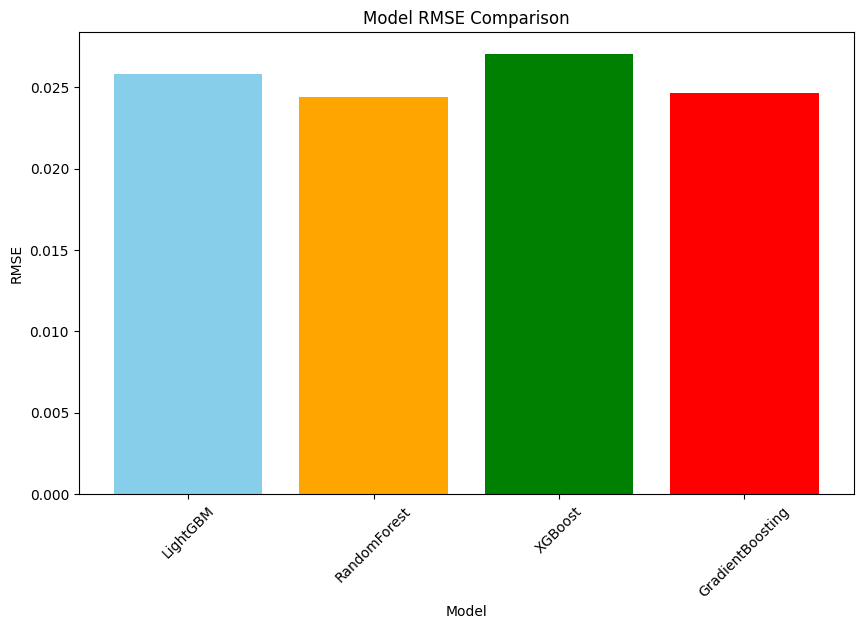

In [28]:
# Visualize RMSE results
plt.figure(figsize=(10, 6))
plt.bar(results_rmse.keys(), results_rmse.values(), color=['skyblue', 'orange', 'green', 'red'])
plt.title('Model RMSE Comparison')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()


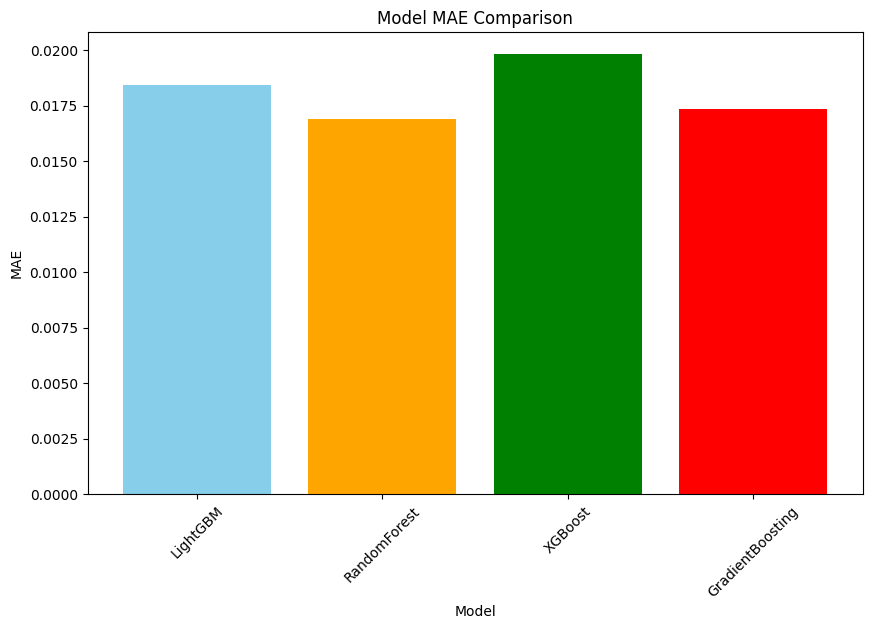

In [29]:
# Visualize MAE results
plt.figure(figsize=(10, 6))
plt.bar(results_mae.keys(), results_mae.values(), color=['skyblue', 'orange', 'green', 'red'])
plt.title('Model MAE Comparison')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.show()